# Some Title

Data recorded through app  
Ability to export data as CSV or email body 


## CONTENTS:
* [File Import](#file-import)
* [Parse and Organize the Data](#parse)
* [Convert Dates and Times](#datetime)
* [Calculations](#calculations)
* [Combine the Datasets](#combine-datasets)
* [Additional Calculations](#additional-calculations)
* [Output File](#output-file)


### File Import <a name="file-import"></a>

Import from CSV, with an option to import from the email body pasted into a .txt file. 

In [1]:
csv_file = open("violet.csv", "r")
violet_raw = csv_file.read()
csv_file.close()

# text_file = open("violet.txt", "rt", newline='\n')
# violet_raw = text_file.read()
# text_file.close()

### Parse and Organize the File <a name="parse"></a>

Parse through the table. 

In [2]:
import re

#divide the file into eat and sleep
violet_raw_pieces = re.split('Sleeping summary from all date ranges', violet_raw, re.DOTALL)
violet_eat_raw = violet_raw_pieces[0]
violet_sleep_raw = violet_raw_pieces[1]

# Parse out the relevant data
# For parsing from the CSV file
violet_eat_regex = re.findall(
    '(\w{3} \d{1,2} \d{4}),|(?:(\d{1,2}:\d{2} [ap]m),(\d{1,2}:\d{2} [ap]m),(\d*) minutes?,(.*?),)'
    , violet_eat_raw
    , re.DOTALL)
violet_sleep_regex = re.findall(
    '(\w{3} \d{1,2} \d{4}),|(?:(\d{1,2}:\d{2} [ap]m),(\d{1,2}:\d{2} [ap]m),(\d*) hrs? (\d*) mins?,)'
    , violet_sleep_raw
    , re.DOTALL)
# For parsing from the text file
# violet_eat_regex = re.findall(
#     '(\w{3} \d{1,2}, \d{4})	|(?:(\d{1,2}:\d{2} [ap]m)	(\d{1,2}:\d{2} [ap]m)	\d* minutes?	(.*?)	)'
#     , violet_eat_raw
#     , re.DOTALL)

# Combine the rows with date only into the rows with other data
date = ''
violet_eat_clean = []
for i, v in enumerate(violet_eat_regex):
    if v[0]:
        date = v[0]
    elif not v[0]:
        violet_eat_clean.append({'date':date, 'start_time':v[1], 'end_time':v[2],'minutes':int(v[3]), 'notes':v[4]})

date = ''
violet_sleep_clean = []
for i, v in enumerate(violet_sleep_regex):
    if v[0]:
        date = v[0]
    elif not v[0]:
        violet_sleep_clean.append({'date':date, 'start_time':v[1], 'end_time':v[2],'minutes':int(v[3])*60 + int(v[4])})

### Convert Dates and Times  <a name="datetime"></a>

In [3]:
# Clean up the times and find the differences between them. 
from datetime import datetime, time, timedelta

for v in violet_eat_clean:
#     v['date'] = datetime.strptime(v['date'], '%b %d, %Y') #for text file
    v['date'] = datetime.strptime(v['date'], '%b %d %Y').date() #for csv file
    
    if type(v['end_time']) is not datetime:
        v['end_time'] = datetime.strptime(v['end_time'], '%I:%M %p').time()
    if type(v['start_time']) is not datetime:
        v['start_time'] = datetime.strptime(v['start_time'], '%I:%M %p').time()
    
    if v['notes'] == 'Nursed from right breast':
        v['notes'] = 'right'
    elif v['notes'] == 'Nursed from left breast':
        v['notes'] = 'left'
    elif re.search('oz', v['notes']) is not None:
        ounces = re.search('(\d*\.\d*)', v['notes'])
        if ounces is not None:
            v['oz'] = float(ounces.group())
        v['notes'] = 'bottle'

    
for v in violet_sleep_clean:
#     v['date'] = datetime.strptime(v['date'], '%b %d, %Y') #for text file
    v['date'] = datetime.strptime(v['date'], '%b %d %Y').date() #for csv file
    
    if type(v['end_time']) is not datetime:
        v['end_time'] = datetime.strptime(v['end_time'], '%I:%M %p').time()
    if type(v['start_time']) is not datetime:
        v['start_time'] = datetime.strptime(v['start_time'], '%I:%M %p').time()


### Calculations  <a name="calculations"></a>

In [4]:
import pandas as pd
violet_eat_df = pd.DataFrame.from_dict(violet_eat_clean)
violet_sleep_df = pd.DataFrame.from_dict(violet_sleep_clean)

for i,row in violet_eat_df.iterrows():
#     print(row['end_time'])
    if row['start_time'] > row['end_time']:
# add a new row for the next day, after midnight
        violet_eat_df.loc[len(violet_eat_df)] = [row['date'] + timedelta(days=1), 
                                          row['end_time'], 
                                          max(row['minutes'] - (1440 -(row['start_time'].hour*60 + row['start_time'].minute)),0),
                                          row['notes'], 
                                          #row['oz'], 
                                          time()]
# update the current row to end before midnight
        violet_eat_df.loc[i, 'end_time'] = time(23,59)
        violet_eat_df.loc[i, 'minutes'] = min(1440 - (row['start_time'].hour*60 + row['start_time'].minute), row['minutes'])

for i,row in violet_sleep_df.iterrows():
#     print(row['end_time'])
    if row['start_time'] > row['end_time']:
# add a new row for the next day, after midnight
        violet_sleep_df.loc[len(violet_sleep_df)] = [row['date'] + timedelta(days=1), 
                                          row['end_time'], 
                                          max(row['minutes'] - (1440 -(row['start_time'].hour*60 + row['start_time'].minute)),0),
                                          time()]
# update the current row to end before midnight
        violet_sleep_df.loc[i, 'end_time'] = time(23,59)
        violet_sleep_df.loc[i, 'minutes'] = min(1440 - (row['start_time'].hour*60 + row['start_time'].minute), row['minutes'])
        
    
violet_eat_df['duration'] = violet_eat_df.apply(lambda row: (row['end_time'].hour*60 + row['end_time'].minute) - 
                (row['start_time'].hour*60 + row['start_time'].minute), axis=1)

violet_sleep_df['duration'] = violet_sleep_df.apply(lambda row: (row['end_time'].hour*60 + row['end_time'].minute) - 
                (row['start_time'].hour*60 + row['start_time'].minute), axis=1)

### Combine the Datasets  <a name="combine-datasets"></a>

Combine the eat and sleep datasets

In [5]:
violet_df = pd.concat([violet_eat_df, violet_sleep_df], keys=['eat', 'sleep'])

violet_df.reset_index(level=0, inplace=True)
violet_df.rename(columns={'level_0':'type'}, inplace=True)
violet_df.reset_index(level=0, drop=True, inplace=True)

### Additional Calculations  <a name="additional-calculations"></a>

Do some calculations for the arc output

In [6]:
first_date = min(violet_df['date'])

for i,row in violet_df.iterrows():
    violet_df.loc[i, 'cum_days'] = int((row['date']-first_date).days)
    violet_df.loc[i, 'start_minutes'] = int(row['start_time'].hour*60 + row['start_time'].minute)
    if (row['start_time'].hour >= 18) or (row['start_time'].hour <= 7): 
        daynight = 'night' 
    else: 
        daynight = 'day'
    violet_df.loc[i, 'daynight'] = daynight
    
    
    

### Output File  <a name="output-file"></a>

Write out to CSV

In [7]:
violet_df.to_csv('violet_cleaned.csv', index_label=['index'])

Create aggregated version

In [8]:
violet_daily_sums = violet_df[['type', 'cum_days', 'date', 'minutes', 'duration']].groupby(['date','type', 'cum_days'], as_index=False).aggregate(sum)

In [9]:
# Calculate a running average, for each type
violet_daily_sums_running_eat = violet_daily_sums[violet_daily_sums['type']=='eat'].rolling(5, on='cum_days').mean()
violet_daily_sums_running_sleep = violet_daily_sums[violet_daily_sums['type']=='sleep'].rolling(5, on='cum_days').mean()

# Put the files with the running average back together 
violet_daily_sums_calcs = pd.concat([violet_daily_sums, pd.concat([violet_daily_sums_running_eat, violet_daily_sums_running_sleep])], keys=['base','mean'])
# Reset the indexes
violet_daily_sums_calcs.reset_index(level=0, inplace=True)
violet_daily_sums_calcs.rename(columns={'level_0':'metric_type'}, inplace=True)
violet_daily_sums_calcs.reset_index(level=0, drop=True, inplace=True)
# Combine type and metric_type columns for plotting
violet_daily_sums_calcs['metric_and_type'] = violet_daily_sums_calcs['type'] + violet_daily_sums_calcs['metric_type']

violet_daily_sums_calcs['cum_days'] = violet_daily_sums_calcs['cum_days'].astype(int)

In [10]:
violet_daily_sums_calcs.to_csv('violet_daily_sums.csv', index_label=['index'])

Another aggregated version for daynight

In [11]:
violet_daynight_sums = violet_df[['type', 'cum_days', 'date', 'minutes', 'duration', 'daynight']].groupby(['date','type', 'cum_days', 'daynight'], as_index=False).aggregate(sum)

In [12]:
violet_daynight_sums.to_csv('violet_daynight_sums.csv', index_label=['index'])

In [ ]:
# Seaborn

In [13]:
import seaborn
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import math
# function to floor data to the nearest hour
def hourFloor(x, base=60):
    return int(base * math.floor(float(x)/base))

def hourCeiling(x, base=60):
    return int(base * math.ceil(float(x)/base))

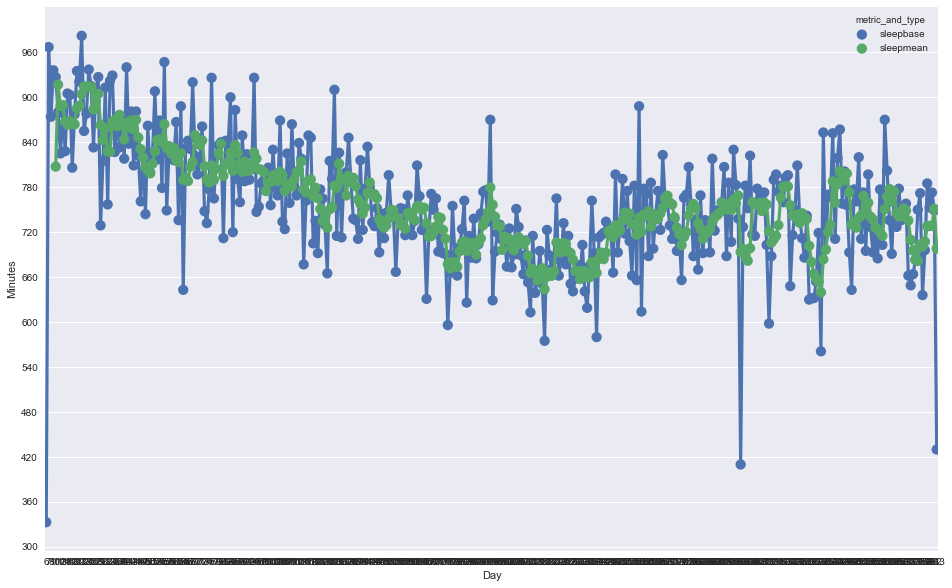

In [14]:
# seaborn.pointplot(x="cum_days", y="minutes", data=violet_daily_sums_calcs, hue='metric_and_type')

y_tick_min = hourFloor(violet_daily_sums_calcs[violet_daily_sums_calcs['type']=='sleep']['minutes'].min())
y_tick_max = hourCeiling(violet_daily_sums_calcs[violet_daily_sums_calcs['type']=='sleep']['minutes'].max())

asdf = seaborn.pointplot(x="cum_days", y="minutes"
                  , data=violet_daily_sums_calcs[violet_daily_sums_calcs['type']=='sleep']
                  , hue='metric_and_type') \
                  .set(yticks=range(y_tick_min,y_tick_max,60)
                       , xlabel='Day'
                       , ylabel='Minutes');
# asdf._legend.set_title('Legend')

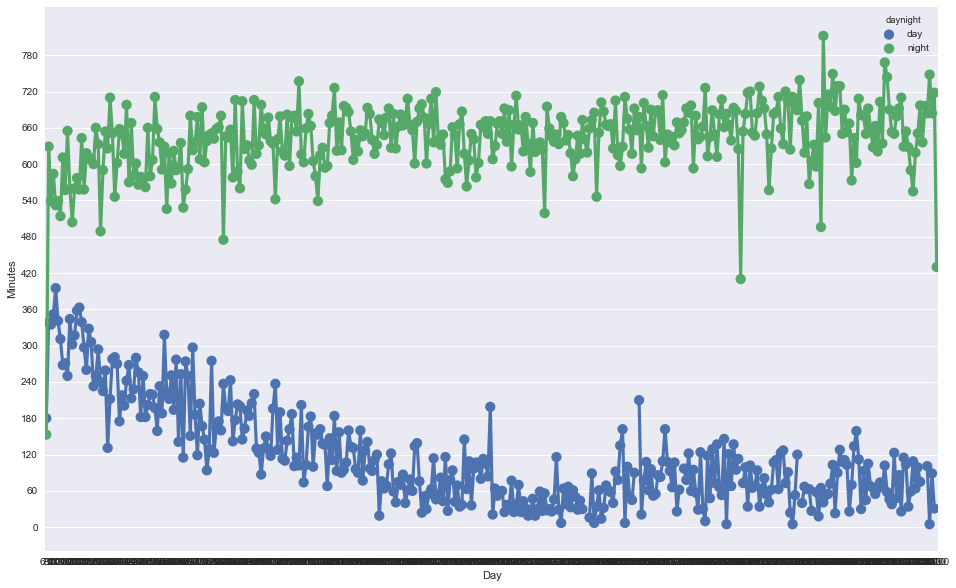

In [15]:
# seaborn.pointplot(x="cum_days", y="minutes", data=violet_daily_sums_calcs, hue='metric_and_type')

y_tick_min = hourFloor(violet_daynight_sums[violet_daynight_sums['type']=='sleep']['minutes'].min())
y_tick_max = hourCeiling(violet_daynight_sums[violet_daynight_sums['type']=='sleep']['minutes'].max())

daynight = seaborn.pointplot(x="cum_days", y="minutes"
                  , data=violet_daynight_sums[violet_daynight_sums['type']=='sleep']
                  , hue='daynight') \
                  .set(yticks=range(y_tick_min,y_tick_max,60)
                       , xlabel='Day'
                       , ylabel='Minutes');
# asdf._legend.set_title('Legend')

In [16]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.5.5/d3.min'
//       d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
      ,tip: '//labratrevenge.com/d3-tip/javascripts/d3.tip.v0.6.3'
  }
});


<IPython.core.display.Javascript object>

In [17]:
%%html
<style>
          
          .eat {
              fill: #fc8d59;
          }
          
          .sleep {
              fill: #91bfdb;
          }
        
          .arc {
              position: absolute;
              z-index:500;  
              
          }
    
          .arc:hover { 
            opacity:.5;
          }
            


          .d3-tip {
              line-height: 1;
              font-weight: bold;
              padding: 12px;
              background: rgba(0, 0, 0, 0.8);
              color: #fff;
              border-radius: 2px;
              position: absolute;
              z-index:1000;
            }

            /* Creates a small triangle extender for the tooltip */
          .d3-tip:after {
              box-sizing: border-box;
              display: inline;
              font-size: 10px;
              width: 100%;
              line-height: 1;
              color: rgba(0, 0, 0, 0.8);
              content: "\25BC";
              position: absolute;
              text-align: center;
            }

            /* Style northward tooltips differently */
          .d3-tip.n:after {
              margin: -1px 0 0 0;
              top: 100%;
              left: 0;
            }
            
          .label {
              position: absolute;
              z-index:1000;
          }
        
        
        
      </style>

In [18]:
%%javascript
console.log('asdf0');
require(['d3'], function(d3){
    console.log('d3 loaded');
    require(['tip'], function(tip){

    console.log('asdf1');
  $("#chart1").remove();
  element.append("<div id='chart1'></div>");
  $("#chart1").width("960px");
  $("#chart1").height("960px");    


        var data;
        var w = 900;
        var h = 900;
        var arc_width = 1;


//   			window.onload = function () {
  				d3.text("violet_cleaned.csv", function(unparsedData) {
  					console.log('asdf2');
                    data = d3.csv.parse(unparsedData);
                    console.log(data);

                    var tip = d3.tip()
                      .attr('class', 'd3-tip')
                      .offset([-10, 0])
                      .html(function(d) {
                        return "<strong>Date:</strong> <span style='color:red'>" + d.date + "</span></br>"+
                            "<strong>Minutes:</strong> <span style='color:red'>" + d.minutes + "</span></br>";
                      })

                    

                    
                    // Arc for paths surrounding the pie chart.
                    var pathArc = d3.svg.arc();
//                        .innerRadius(w/6)
//                        .outerRadius(w/6+2);
//                        .startAngle(0);
                    
                    // Appending SVG to the body
                    var svg = d3.select("#chart1").append("svg")
                        .attr("width", w)
                        .attr("height", h);
                    
                    svg.call(tip);
                    
                    var midnight = svg.append("text")
                        .attr("x", (w/2))
                        .attr("y", (40))
                        .attr("text-anchor", "middle")
                        .style("font-size", "16px")
                        .style("font-family", "sans-serif")
                        .text("Midnight")
                        .attr("class","label");
                    
                    var noon = svg.append("text")
                        .attr("x", (w/2))
                        .attr("y", (h-40))
                        .attr("text-anchor", "middle")
                        .style("font-size", "16px")
                        .style("font-family", "sans-serif")
                        .text("Noon")
                        .attr("class","label");
                    
                    
                    
                    
                    
                    // Curved paths surrounding the pie chart g (groups) container.
                    var curves = svg.append("g")
                        .attr("transform", "translate(" + w / 2 + "," + h / 2 + ")");
                    
                        // Appending the curve path endAngle to show percentage of data[curvePercent]
                    curves.selectAll("path")
                        .data(data)
                      .enter().append("path")
                        .each(arcFunction)
                            .on('mouseover', tip.show)
                            .on('mouseout', tip.hide);
//                        .style("fill", function(d) { return colours(colourValue(d));});
                    
                        // Function called for each path appended to increase scale and iterate.
                    function arcFunction(d, i){
                        return d3.select(this)
                            .transition()
                                .ease('bounce')
                                .duration(1200)
                                .attr("d", pathArc.startAngle( (2 * Math.PI) * (Math.round(data[i].start_minutes)/1439)))
                                .attr("d", pathArc.endAngle( (2 * Math.PI) * ((Math.round(data[i].start_minutes) + Math.round(data[i].minutes))/1439)))
                                .attr("d", pathArc.innerRadius( arc_width + data[i].cum_days*arc_width))
                                .attr("d", pathArc.outerRadius( arc_width + data[i].cum_days*arc_width+arc_width))
//                                .attr("transform", "scale(1." + Math.sqrt(Math.round(data[i].cum_days)) + ")");

                                .attr("class", function(d) {
                                    if (d.type != 'eat') {return 'arc sleep'}
                                    else 	{ return 'arc eat' }
                                });
                        
                                
//                                .style("fill", function(d) {
//                                    if (d.type != 'eat') {return '#91bfdb'}
//                                    else 	{ return '#fc8d59' }
//                                });
                          
                    }
                    
                    
                


  				})
//   			}
    })
});





<IPython.core.display.Javascript object>